# GSM of C. necator: model validation

### load in modules

In [34]:
import pandas as pd
import cobra
from cobra.flux_analysis import pfba
import json
import matplotlib.pyplot as plt
from cobra import Model, Reaction, Metabolite
import numpy as np
from cobra.flux_analysis.variability import flux_variability_analysis
from matplotlib_venn import venn3, venn2

In [35]:
m = cobra.io.read_sbml_model('../Model/iCN1361.xml')


## Carbon source utilisation

#### load in in vivo phenotypes

In [22]:
carbon_sources = pd.read_excel('Data/Carbon_source_utilisation_phenotypes.xlsx', sheet_name='Sheet1')


#### Match the substrate names to the IDs used in the model 

In [23]:

substrates = list(carbon_sources['Metabolite ID'])
substrates2 = []
match = {}
match2 = {}
for i in substrates:
    if i[0:3] != 'M_':
        substrates2.append('M_'+i)
        match['M_' + i] = i
        match2[i] = 'M_' + i
    else:
        substrates2.append(i)
        match[i] = i
        match2[i] = i

### Simulate growth on each substrate in the model

In [24]:

# set the constraints
m.reactions.EX_BETA_D_FRUCTOSE_e.bounds = (0.0, 0.0)
m.reactions.EX_CARBON_DIOXIDE_e.bounds = (0.0, 1000.0)
m.reactions.R_ATPM.bounds = (3.0, 1000.0)
m.objective = 'R_Biomass'
m.objective_direction = 'max'
m.reactions.R_Biomass.bounds = (0.0, 1000.0)

media = ['EX_OXYGEN_MOLECULE_e', 'EX_AMMONIUM_e', 'EX_SULFATE_e', 'EX_FE2_e', 'EX_Pi_e', 'EX_PROTON_e', 'EX_WATER_e']


for i in m.reactions:
    if i.id not in media:
        if 'EX_' in i.id:
            if '_e' in i.id:
                i.bounds = (0.0, 1000.0)
            else:
                i.bounds = (0.0, 0.0)
    else:
        i.bounds = (-1000.0, 1000.0)


growth_phenotypes = {}
# check to see if metabolite in the model
for met in substrates2:
    #print(met)
    
    # check if in the model
    if met in m.metabolites:
        
        with m:
            # add transport reaction if not already in the model
            tx_name1 = 'EX_' + met 
            tx_name2 = 'EX_' + met.split('M_')[1] + '_e'
            if tx_name1 not in m.reactions and tx_name2 not in m.reactions:
                reaction = Reaction(met + '_tx')
                reaction.name = met + ' transporter'
                reaction.lower_bound = -10.0
                reaction.upper_bound = 0.0
                reaction.add_metabolites({m.metabolites.get_by_id(met) : -1.0})
                m.add_reaction(reaction)
            elif tx_name1 in m.reactions:
                m.reactions.get_by_id(tx_name1).bounds = (-10.0, 0.0)
            elif tx_name2 in m.reactions:
                m.reactions.get_by_id(tx_name2).bounds = (-10.0, 0.0)
                

                
                
            # check whether solution exists
            try:
                
                sol = pfba(m)
                #print(reaction.id, sol[reaction.id], sol['R_Biomass'])
                if sol['R_Biomass'] > 0.01:
                    growth_phenotypes[met] = 1.0
                else:
                    growth_phenotypes[met] = 0.0
            except:
                growth_phenotypes[met] = 0.0
    else:
        growth_phenotypes[met] = 0.0
        
        
        





In [28]:
### Print results to dataframe
df = pd.DataFrame(index = substrates2)

GSM_phenotypes = []
Experimental_phenotypes = []
substrate = []
metabolite_ID = []
result = []

FP = 0
FN = 0
TP = 0
TN = 0
false_positives = []
false_negatives = []

for i, j in growth_phenotypes.items():
    if j == 1.0:
        for ind, met in enumerate(carbon_sources['Metabolite ID']):
            if met == match[i]:
                if carbon_sources['Experimental'][ind] == 'X':
                    result.append('FP')
                    GSM_phenotypes.append('O')
                    Experimental_phenotypes.append('X')
                    metabolite_ID.append(met)
                    substrate.append(carbon_sources['Substrate'][ind])
                    FP += 1
                    false_positives.append(i)
                    
                elif carbon_sources['Experimental'][ind] == 'O':
                    result.append('TP')
                    GSM_phenotypes.append('O')
                    Experimental_phenotypes.append('O')
                    metabolite_ID.append(met)
                    substrate.append(carbon_sources['Substrate'][ind])
                    TP += 1
                    
                    
    if j == 0.0:
        for ind, met in enumerate(carbon_sources['Metabolite ID']):
            if met == match[i]:
                if carbon_sources['Experimental'][ind] == 'X':
                    result.append('TN')
                    GSM_phenotypes.append('X')
                    Experimental_phenotypes.append('X')
                    metabolite_ID.append(met)
                    substrate.append(carbon_sources['Substrate'][ind])
                    TN += 1
                    
                    
                elif carbon_sources['Experimental'][ind] == 'O':
                    result.append('FN')
                    GSM_phenotypes.append('X')
                    Experimental_phenotypes.append('O')
                    metabolite_ID.append(met)
                    substrate.append(carbon_sources['Substrate'][ind])
                    FN += 1
                    false_negatives.append(i)

df.insert(0, column = 'Substrate', value = substrate)
df.insert(1, column = 'Metabolite ID', value = metabolite_ID)
df.insert(2, column = 'GSM phenotype', value = GSM_phenotypes)
df.insert(3, column = 'Experimental phenotype', value = Experimental_phenotypes)
df.insert(4, column = 'Result', value = result)

print('Number of tested carbon sources: ', len(substrates2))
print('Number of true positives: ', TP)
print('Number of false positives: ', FP)
print('Number of true negatives: ', TN)
print('Number of false negatives: ', FN)
overall_accuracy = (TP+TN)/(TP+TN+FP+FN)
print('Overall accuracy: ',  overall_accuracy)

Number of tested carbon sources:  131
Number of true positives:  62
Number of false positives:  15
Number of true negatives:  52
Number of false negatives:  2
Overall accuracy:  0.8702290076335878


### Save to excel file

In [31]:
df.to_excel('SupplementaryFile2_CarbonSourceUtilisation.xlsx')

## Validation of fluxes for frowth on fructose

### Prediction of external fluxes

In [36]:


# turn all uptake transports off if not in media
media = ['EX_OXYGEN_MOLECULE_e', 'EX_AMMONIUM_e', 'EX_SULFATE_e', 'EX_FE2_e', 'EX_Pi_e']

for i in m.reactions:
    if i.id not in media:
        if 'EX_' in i.id:
            if '_e' in i.id:
                i.bounds = (0.0, 1000.0)
            else:
                i.bounds = (0.0, 0.0)
    else:
        i.bounds = (-1000.0, 1000.0)
            
m.reactions.EX_BETA_D_FRUCTOSE_e.bounds = (-2.6, -2.6)
m.reactions.R_FRUPTS.bounds = (0.0, 0.0) # previous study found the ABC is the active reaction [ref]
m.objective = 'R_Biomass'
sol_fru = pfba(m)

print('Growth rate: ', sol_fru['R_Biomass'])
for i in m.reactions:
    if 'EX_' in i.id:
        if abs(sol_fru[i.id]) > 0.0:
            print(i.id, sol_fru[i.id])

Growth rate:  0.2510580527153153
EX_OXYGEN_MOLECULE_e -4.909673110304909
EX_AMMONIUM_e -2.630871817039055
EX_WATER_e 11.951833486031049
EX_PROTON_e 2.311507343016943
EX_CARBON_DIOXIDE_e 5.20836937160187
EX_SULFATE_e -0.04060446894821441
EX_Pi_e -0.22327608505539098
EX_BETA_D_FRUCTOSE_e -2.6
EX_FE2_e -0.0012257098506314997
EX_CH33ADO_e 0.001783547286630084


|  Substrate           | In vivo flux  | In silico flux |
|------------------|---------------|---------------|
| Fructose     | -2.6 |   -2.6* |
| Oxygen  | -4.6+/-0.3 |  -4.91 |
| Sulfate    | - |   -0.04 |
| Carbon dioxide  | - |  5.21 |
| Ammonium | - |    -2.63 |  
| Phosphate | - |   -0.22 |
| Growth rate | 0.25+/-0.08 |  0.25 |


### Prediction of internal fluxes using 13-C MFA analysis

#### load 13-C data

In [37]:

c13_model = pd.read_excel('Data/C13_MFA_results.xlsx', sheet_name='Sheet1')
reac_mappings = pd.read_excel('Data/ReactionName_mappings.xlsx', sheet_name='Sheet1')


R correlation coefficient:  0.9388041503107685 p-value:  6.751401631820812e-16
R-Squared correlation coefficient:  0.881353232640724


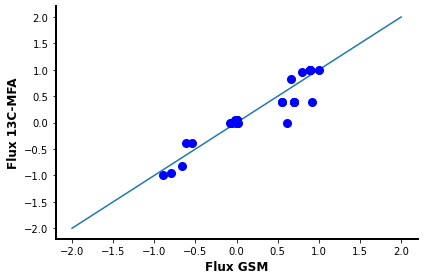

In [38]:


# Exclude the anaplerosis reactions
reactions_exclude = ['R_OXALODECARB_RXN', 'R_PEPSYNTH_RXN', 'R_PEPDEPHOS_RXN', 'R_PEPCARBOX_RXN', 'R_PEPCARBOX_RXN2', 'R_MALIC_NADP_RXN']

# Compare the results and add to list for correlation
gsm_vals = []
c13_vals = []
c13_vals2 = {}
gsm_vals2 = {}
for ind, r in enumerate(c13_model['Reaction ID']):
    reacs = r.split(';')
    if reacs[0] not in reactions_exclude:
        if len(reacs) > 1.0:
            sum_flux = 0.0
            for reaci in reacs:
                sum_flux += sol_fru[reaci]/2.6 # normalise the flux to 1 mmol/gDCW/h of fructose

            c13_vals.append(float(c13_model['13C-MFA'][ind]))
            c13_vals2[reaci] = c13_model['13C-MFA'][ind]
            gsm_vals.append(float(sum_flux))
            gsm_vals2[reaci] = float(sum_flux)
           
        else:
            c13_vals.append(float(c13_model['13C-MFA'][ind]))
            gsm_vals.append(float(sol_fru[reacs[0]]/2.6))
            c13_vals2[reacs[0]] = c13_model['13C-MFA'][ind]
            gsm_vals2[reacs[0]] = sol_fru[reacs[0]]/2.6
                 
        
        
from scipy import stats

x = np.linspace(-2, 2,2)
y = x
plt.plot(x, y)

plt.plot(gsm_vals, c13_vals, 'bo', markersize = 8)
axes = plt.gca()

plt.rc('axes', linewidth = 2.0)
plt.xticks(fontsize=10, weight = 'normal')
plt.yticks(fontsize=10, weight = 'normal')

axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.xlabel('Flux GSM', fontsize = 12, weight = "bold")
plt.ylabel('Flux 13C-MFA', fontsize = 12, weight = "bold")
plt.savefig('C13_Correlation.png', format = 'png')
plt.tight_layout()
slope, intercept, r_value_bio_out, p_value, std_err = stats.linregress(gsm_vals, c13_vals)
print('R correlation coefficient: ', r_value_bio_out, 'p-value: ', p_value)
print('R-Squared correlation coefficient: ', r_value_bio_out**2)

#### Flux variability analysis to whether the 13C flux values lie within the ranges at 90% of the optimal

In [15]:
C13reacs = [] # only run FVA on the reactions in central carbon metabolism to save time
for ind, r in enumerate(c13_vals2.keys()):
    reacs = r.split(';')
    for reac in reacs:
        C13reacs.append(reac)

In [16]:
res90 = flux_variability_analysis(m, fraction_of_optimum = 0.9, reaction_list=C13reacs, processes = 6, pfba_factor= 1.2)


In [17]:
count = 0.0
for ind, i in enumerate(res90['minimum']):
    if res90['minimum'].index[ind] in c13_vals2:
        if res90['minimum'][ind]/2.6 <= c13_vals2[res90['minimum'].index[ind]] <= res90['maximum'][ind]/2.6:
            count += 1.0
        else:
            print(res90['minimum'].index[ind], i/2.6, res90['maximum'][ind]/2.6, c13_vals2[res90['minimum'].index[ind]]) 
            
print('Number of reactions that agree with the FVA ranges: ', count)

R_2TRANSKETO_RXN -0.3721298842952905 -0.050078361945076026 -0.008
R_RIBULP3EPIM_RXN -0.7107119044153983 -0.06660885971498921 -0.008
R_PHOSGLYPHOS_RXN -0.8160712622890833 0.991537995392259 -0.95
R_GAPOXNPHOSPHN_RXN -0.991537995392311 0.8160712622890811 0.95
R_CITSYN_RXN 0.49513620903133826 1.5112961887474 0.393
R_ACONITATEDEHYDR_RXN 0.49513620903133826 1.276617353380889 0.393
R_ISOCIT_CLEAV_RXN 2.9410900479095282e-05 1.150445479378119 0.0
R_FUMHYDR_RXN -1.224917171780078 -0.40252038729814776 -0.393
Number of reactions that agree with the FVA ranges:  25.0


#### Save to excel file

In [18]:
df = pd.DataFrame(index = gsm_vals2.keys())


gsm_flux = []
c13_flux = []
reacs_stoich = []
FVA_min = []
FVA_max = []
for ind, i in enumerate(gsm_vals2.keys()):
    gsm_flux.append(gsm_vals2[i])
    c13_flux.append(c13_vals2[i])
    FVA_min.append(res90['minimum'][i])
    FVA_max.append(res90['maximum'][i])
    reacs_stoich.append(m.reactions.get_by_id(i).reaction)
    
df.insert(0, column = 'Reaction', value = reacs_stoich)   
df.insert(1, column = '13C-MFA flux', value = c13_flux)
df.insert(2, column = 'GSM flux (pFBA)', value = gsm_flux)
df.insert(3, column = 'FVA (min.)', value = FVA_min)
df.insert(4, column = 'FVA (max.)', value = FVA_max)


In [20]:
df.to_excel('SupplementaryFile3_13CMFA.xlsx')


#### Plot the barcharts comparing 13-C and GSM flux values (Figure 1b)

In [163]:
reac_index = {}
reac_titles = {}
for ind, r in enumerate(reac_mappings['Reaction']):
    reac_index[r] = reac_mappings['Index'][ind]
    reac_titles[r] = reac_mappings['Abbreviation'][ind]
    

In [164]:
# plot the fluxes of each condition on the plot

x = np.arange(2)  # the label locations
rev = [34, 36, 18, 15, 20, 10, 2, 21]
# folder to save files to
folder_name = '../../barcharts_13c/'
cit = 0
for indr, r in enumerate(reac_mappings['Reaction']): 
    if r in c13_vals2.keys():
        if reac_mappings['Index'][indr] in rev:

            y = [abs(c13_vals2[r]), abs(gsm_vals2[r])]
        elif reac_mappings['Index'][indr] == 13:
            y = [-(c13_vals2[r]), abs(gsm_vals2[r])]
        else:
            if abs((c13_vals2[r])) < 0.001 and abs((gsm_vals2[r])) < 0.001:
                y = [0.0, 0.0]
            elif abs((c13_vals2[r])) >= 0.001 and abs((gsm_vals2[r])) < 0.001:
                y = [(c13_vals2[r]), 0.0]
            elif abs((c13_vals2[r])) < 0.001 and abs((gsm_vals2[r])) >= 0.001:
                y = [0.0, gsm_vals2[r]]
            else:
                y = [c13_vals2[r], gsm_vals2[r]]

        ax = plt.figure()
        plt.rc('axes', linewidth = 6.0)
        barlist = plt.bar(x, y, align='center', alpha=0.8, ecolor='black', capsize=10,error_kw=dict(lw=7, capsize=10, capthick=7),  linewidth = 4)
        barlist[0].set_color('darkred')
        barlist[0].set_edgecolor('k')
        barlist[0].set_linewidth(10)
        barlist[1].set_color('darkblue')
        barlist[1].set_edgecolor('k')
        barlist[1].set_linewidth(10)



        font = {'family' : 'bold',
                'weight' : 'bold',
                'size'   : 85}

        plt.rc('font', **font)

        plt.xticks([])
        barlist[0].axes.spines['right'].set_visible(False)
        barlist[0].axes.spines['top'].set_visible(False)
        barlist[0].axes.spines['bottom'].set_visible(False)
        barlist[0].axes.spines['left'].set_color('black')
        barlist[0].axes.spines['left'].set_linewidth(10)


        x1 = np.array([0, 1])
        y = np.array([0, 0])
        plt.plot(x1, y, 'k', linewidth = 10)
        plt.xlabel(reac_mappings['Abbreviation'][indr], fontweight = 'bold')
        plt.title(reac_mappings['Index'][indr])


        plt.rc('font', **font)
        plt.savefig(folder_name+str(reac_mappings['Index'][indr]) + '_' + str(reac_mappings['Abbreviation'][indr]) + '.png',  bbox_inches = 'tight')






#### Plot the FVA flux ranges (Figure 1c)

In [165]:
import numpy as np
import matplotlib.pyplot as plt

objects = c13_vals2.keys() 
y_pos = np.arange(len(objects))
x = np.array(range(len(objects)))
min_val = []
max_val = []
span = []
for ind, i in enumerate(c13_vals2.keys()):
    min_val.append(res90['minimum'][ind]/2.6)
    max_val.append(res90['maximum'][ind]/2.6)
    span.append(res90['maximum'][ind]/2.6 - res90['minimum'][ind]/2.6)
    
    
    
fig, ax = plt.subplots(figsize=(9,10))   
#ax.barh(width=width, left=start, height=0.3, y=yval)
#ax.barh(bottom=yval, width=width, left=start, height=0.3)
ax.barh(width = span, left=min_val, height=0.8, y = y_pos, alpha=0.5)
plt.scatter(c13_vals, y_pos, c = 'darkred')
plt.scatter(gsm_vals, y_pos, c = 'darkblue')

reac_Ids = []
for i in C13reacs:
    reac_Ids.append(reac_titles[i])
plt.yticks(y_pos, reac_Ids)
#plt.ylim(0)
plt.ylabel('Reaction', fontsize = 16, weight = "bold")
plt.xlabel('Flux (mmol/gDCW/h)', fontsize = 16, weight = "bold")
plt.rc('axes', linewidth = 1.5)
plt.xticks(fontsize=16, weight = 'normal')

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.yticks(fontsize=14, weight = 'normal')
plt.tight_layout()
plt.setp(ax.spines.values(), linewidth=1.5)
plt.savefig('Figure1c.svg', format= 'svg', bbox_inches='tight')


### Calculation of P/O ratio

In [39]:
print('P/O ratio (ATP production / Oxygen atoms) :', sol_fru['R_ATPSynth']/abs(sol_fru['EX_OXYGEN_MOLECULE_e']*2.0))


P/O ratio (ATP production / Oxygen atoms) : 1.6315080984351191


## Single gene deletion phenotypes - comparison to SBRC TraDIS gene essentiality study and Tn-Seq essentiality study

### Load the data

In [44]:
# load in the genes and in vivo phenotypes...
IPKM_fmm = pd.read_excel('../SupplementaryFiles/RevisedFiles/GithubFiles_16022022/JupyterNotebooks/Data/TraDIS_results.xlsx', sheet_name = 'IPKM_FMM')
IPKM_sob = pd.read_excel('../SupplementaryFiles/RevisedFiles/GithubFiles_16022022/JupyterNotebooks/Data/TraDIS_results.xlsx', sheet_name = 'IPKM_SOB')
low_coverage = pd.read_excel('../SupplementaryFiles/RevisedFiles/GithubFiles_16022022/JupyterNotebooks/Data/TraDIS_results.xlsx', sheet_name = 'low_coverage')


In [45]:
# take the logarithm + 1 of the IPKM values for both SOB and FMM media conditions
log2_IPKM = {}
for ind, gene in enumerate(IPKM_fmm['Gene ID']):
    log2_IPKM[gene] = np.log2(IPKM_fmm['IPKM_curated'][ind] + 1)
    
log2_IPKM_sob = {}
for ind, gene in enumerate(IPKM_sob['Gene ID']):
    log2_IPKM_sob[gene] = np.log2(IPKM_sob['IPKM_curated'][ind] + 1)
    
   

In [46]:
len(log2_IPKM_sob)

6637

### Get the TraDIS phenotypes

In [48]:
tradis_phenotypes_fmm = {}
tradis_phenotypes_sob = {}

min_threshold = 3.9
max_threshold = 4.4

# low coverage 
low_coverage_fmm = []
low_coverage_sob = []
for ind, i in enumerate(low_coverage['Gene']):
    if low_coverage['Low coverage SOB'][ind] == 1:
        low_coverage_sob.append(i)
    if low_coverage['Low coverage FMM'][ind] == 1:
        low_coverage_fmm.append(i) 
            
        

for gene, IPKM in log2_IPKM.items():
    
    # if the gene is lower than 3.3 in the FMM data and not in the low coverage set of genes, or if it is below 3.3 in the SOB data and not in the low coverage set
    if (log2_IPKM[gene] < min_threshold and gene not in low_coverage_fmm) or (log2_IPKM_sob[gene] < min_threshold and gene not in low_coverage_sob):     
        tradis_phenotypes_fmm[gene] = 2 
        
    # if the gene is greater than 4.4 in the FMM data and greater than 3.3 in the SOB data (n.b: if it is greater than 4.4 in the FMM but in undefined region for SOB then it is still classed as non-essential) or if it is > 4.4 in the FMM media and not > 4.4 in the rich but is in the low coverage genes
    elif (log2_IPKM[gene] > max_threshold and log2_IPKM_sob[gene] > min_threshold) or (log2_IPKM[gene] > max_threshold and gene in low_coverage_sob):
        tradis_phenotypes_fmm[gene] = 0 
        
    else:
        tradis_phenotypes_fmm[gene] = 1
        
        
for gene, IPKM in log2_IPKM_sob.items():
    
    # if the gene is lower than 3.3 in the SOB data and not in the low coverage set of genes
    if (log2_IPKM_sob[gene] < min_threshold and gene not in low_coverage_sob):
        tradis_phenotypes_sob[gene] = 2 
        
    # if the gene is greater than 4.4 in the SOB data 
    elif log2_IPKM_sob[gene] > max_threshold:
        tradis_phenotypes_sob[gene] = 0 
        
    else:
        tradis_phenotypes_sob[gene] = 1
    

    
# print the tradis statistics
tradis_essential = 0
tradis_nonessential = 0
undefined_tradis = 0
for i, j in tradis_phenotypes_fmm.items():
    if j == 2:
        tradis_essential += 1
    elif j == 1:
        undefined_tradis += 1
    elif j == 0:
        tradis_nonessential += 1
        
        
tradis_essential_sob = 0
tradis_nonessential_sob = 0
undefined_tradis_sob = 0
for i, j in tradis_phenotypes_sob.items():
    if j == 2:
        tradis_essential_sob += 1
    elif j == 1:
        undefined_tradis_sob += 1
    elif j == 0:
        tradis_nonessential_sob += 1
        
print('TraDIS essential (FMM): ', tradis_essential)
print('TraDIS non-essential (FMM): ', tradis_nonessential)
print('TraDIS undefined (FMM): ', undefined_tradis)
print('total genes: ', len(tradis_phenotypes_fmm))


print('')
print('Total essential genes (SOB): ', tradis_essential_sob)
print('Total non-essential genes (SOB): ', tradis_nonessential_sob)
print('Number of undefined (SOB): ', undefined_tradis_sob)    
print('total genes: ', len(tradis_phenotypes_sob))

TraDIS essential (FMM):  608
TraDIS non-essential (FMM):  5762
TraDIS undefined (FMM):  267
total genes:  6637

Total essential genes (SOB):  373
Total non-essential genes (SOB):  5918
Number of undefined (SOB):  346
total genes:  6637


### Get the Tn-Seq phenotypes

#### Load the Tn-Seq data

In [1748]:
### load the LB dataset

In [57]:
tn_seq_lb = pd.read_excel('../SupplementaryFiles/RevisedFiles/GithubFiles_16022022/JupyterNotebooks/Data/Jahn2022_files/TnSeq_LBdata.xlsx') # LB data

In [2213]:
### load the fructose essentiality dataset

In [58]:

# tn-seq data comparisons -  downloaded from Michael Jahn's ShinyLab
tn_seq = pd.read_csv('../SupplementaryFiles/RevisedFiles/GithubFiles_16022022/JupyterNotebooks/Data/Jahn2022_files/Cupriavidus_BarSeq_2021.csv') # specific to fructose data

fructose_continuous = tn_seq[tn_seq.condition == 'fructose - continuous']
fructose_continuous_T8 = fructose_continuous[fructose_continuous.timepoint == 8] # extract for time point 8 only

genes = list(set(list(fructose_continuous_T8['locus_tag'])))

# calculate the median value across replicates
fructose_scores = {}
for i in genes:
    score = np.median(fructose_continuous_T8[fructose_continuous_T8.locus_tag == i].fitness_score)
    fructose_scores[i] = score

/opt/anaconda2/envs/pyTFA_2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda2/envs/pyTFA_2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Get the Tn-Seq phenotypes for FMM using both datasets

In [59]:
tnseq_phenotypes = {}
for ind, i in enumerate(tn_seq_lb['locus_tag']):
    
    # assign the essential genes
    if tn_seq_lb['essentiality'][ind] == 2:
        tnseq_phenotypes[i] = 2
    else:
        if i in fructose_scores.keys():
            if str(fructose_scores[i]) != 'nan':
                if fructose_scores[i] < -3:
                    pheno1 = 2
                else:
                    pheno1 = 0
            else:
                pheno1 = 1
        else:
            pheno1 = 1
                       
        if pheno1 == 2:       
            tnseq_phenotypes[i] = 2
        elif tn_seq_lb['essentiality'][ind] == 0 or pheno1 == 0:
            tnseq_phenotypes[i] = 0
        else:
            tnseq_phenotypes[i] = 1

### Number of essential / non-essential / undefined in Tn-Seq data

In [60]:
tnseq_essential = 0
tnseq_nonessential = 0
undefined_tnseq = 0
for i, j in tnseq_phenotypes.items():
    if j == 2:
        tnseq_essential += 1
    elif j == 1:
        undefined_tnseq += 1
    elif j == 0:
        tnseq_nonessential += 1
print('Tn-Seq essential (FMM): ', tnseq_essential)
print('Tn-Seq non-essential (FMM):', tnseq_nonessential)
print('Tn-Seq undefined (FMM): ', undefined_tnseq)
print('Tn-Seq undefined (FMM): ', len(tnseq_phenotypes))

Tn-Seq essential (FMM):  577
Tn-Seq non-essential (FMM): 5752
Tn-Seq undefined (FMM):  220
Tn-Seq undefined (FMM):  6549


In [61]:
tnseq_essential_lb = 0
tnseq_nonessential_lb = 0
undefined_tnseq_lb = 0
for ind, i in enumerate(tn_seq_lb['locus_tag']):
    if tn_seq_lb['essentiality'][ind] == 2:
        tnseq_essential_lb += 1
    elif tn_seq_lb['essentiality'][ind] == 1:
        undefined_tnseq_lb += 1
    elif tn_seq_lb['essentiality'][ind] == 0:
        tnseq_nonessential_lb += 1
        
print('Tn-Seq essential (LB): ', tnseq_essential_lb)
print('Tn-Seq non-essential (LB):', tnseq_nonessential_lb)
print('Tn-Seq undefined (LB): ', undefined_tnseq_lb)
print('total number of genes: ', len(tn_seq_lb))

Tn-Seq essential (LB):  513
Tn-Seq non-essential (LB): 5776
Tn-Seq undefined (LB):  260
total number of genes:  6549


### Venn diagram showing the number of genes that have the same phenotype between the two approaches

#### Essential - all genes

Undefined in TraDIS:  212
Undefined in Tn-Seq:  211


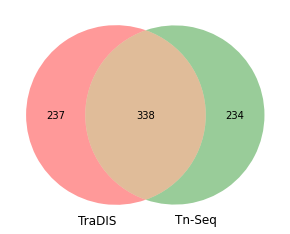

In [2529]:
# only include genes that are in both datasets

essential_tn_seq = []
nonessential_tn_seq = []
undefined_tnseq = []
for i, j in tnseq_phenotypes.items():
    if i in tradis_phenotypes_fmm:
        if j == 2:
            essential_tn_seq.append(i)
        elif j == 0:
            nonessential_tn_seq.append(i)
        else:
            undefined_tnseq.append(i)
        
        
essential_tradis2 = []
nonessential_tradis2 = []
undefined_tradis2 = []  
for i, j in tradis_phenotypes_fmm.items():
    if i in tnseq_phenotypes:
        if j == 2:
            essential_tradis2.append(i)
        elif j == 0:
            nonessential_tradis2.append(i)
        else:
            undefined_tradis2.append(i)

tradis_tnseq_overlap = len(list(set(essential_tradis2) & set(essential_tn_seq)))      
tradis_essential = len(essential_tradis2) - len(list(set(essential_tradis2) & set(essential_tn_seq)))  
tn_seq_essential = len(essential_tn_seq) - len(list(set(essential_tradis2) & set(essential_tn_seq)))  
#tradis_tnseq_overlap = len(list(set(essential_tradis2) & set(essential_tn_seq)))

# Make the diagram
v1 = venn2(subsets = (tradis_essential, tn_seq_essential, tradis_tnseq_overlap), set_labels = ('TraDIS', 'Tn-Seq'))
#plt.savefig('overlapping_essential_genes.pdf')
print('Undefined in TraDIS: ', len(undefined_tradis2))
print('Undefined in Tn-Seq: ', len(undefined_tnseq))

In [2562]:
# 209 genes that are essential in the Tn-Seq but not in the TraDIS data...
# 25 are undefined in the tradis data
# 146 are greater than 6.5 (95% percentile)
# 195 are greater than 4.7 (80th percentile)


#### Non-essential ALL genes

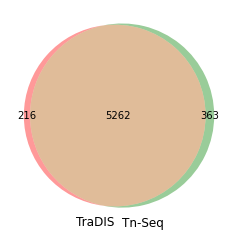

In [2444]:
tradis_tnseq_overlap = len(list(set(nonessential_tradis) & set(nonessential_tn_seq)))


tradis_nonessential = len(nonessential_tradis) - tradis_tnseq_overlap
tn_seq_nonessential = len(nonessential_tn_seq) - tradis_tnseq_overlap

# Make the diagram
v2 = venn2(subsets = (tradis_nonessential, tn_seq_nonessential, tradis_tnseq_overlap), set_labels = ('TraDIS', 'Tn-Seq'))
#plt.savefig('overlapping_essential_genes.pdf')




#### Chromosome 1

Undefined in TraDIS:  139
Undefined in Tn-Seq:  134


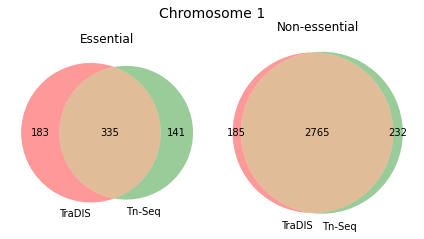

In [2480]:
# only include genes that are in both datasets

essential_tn_seq = []
nonessential_tn_seq = []
undefined_tnseq = []
for i, j in tnseq_phenotypes.items():
    if str(i) != 'nan':
        if 'H16_A' in i:
            if i in tradis_phenotypes_fmm:
                if j == 2:
                    essential_tn_seq.append(i)
                elif j == 0:
                    nonessential_tn_seq.append(i)
                else:
                    undefined_tnseq.append(i)
        
        
essential_tradis2 = []
nonessential_tradis2 = []
undefined_tradis2 = []  
for i, j in tradis_phenotypes_fmm.items():
    if str(i) != 'nan':
        if 'H16_A' in i:
            if i in tnseq_phenotypes:
                if j == 2:
                    essential_tradis2.append(i)
                elif j == 0:
                    nonessential_tradis2.append(i)
                else:
                    undefined_tradis2.append(i)

tradis_tnseq_overlap = len(list(set(essential_tradis2) & set(essential_tn_seq)))        
tradis_essential = len(essential_tradis2) - tradis_tnseq_overlap
tn_seq_essential = len(essential_tn_seq) - tradis_tnseq_overlap

# Make the diagram
figure, axes = plt.subplots(1, 2)
v1 = venn2(subsets = (tradis_essential, tn_seq_essential, tradis_tnseq_overlap), set_labels = ('TraDIS', 'Tn-Seq'), ax = axes[0])
for text in v1.set_labels:
    text.set_fontsize(10)
for text in v1.subset_labels:
    text.set_fontsize(10)
axes[0].title.set_text('Essential')

tradis_tnseq_overlap = len(list(set(nonessential_tradis2) & set(nonessential_tn_seq)))
tradis_nonessential = len(nonessential_tradis2) - tradis_tnseq_overlap
tn_seq_nonessential = len(nonessential_tn_seq) - tradis_tnseq_overlap

v2 = venn2(subsets = (tradis_nonessential, tn_seq_nonessential, tradis_tnseq_overlap), set_labels = ('TraDIS', 'Tn-Seq'), ax = axes[1])
for text in v2.set_labels:
    text.set_fontsize(10)
for text in v2.subset_labels:
    text.set_fontsize(10)
axes[1].title.set_text('Non-essential')
figure.suptitle('Chromosome 1', fontsize=14)

figure.tight_layout()
figure.subplots_adjust(top=1.05)
plt.savefig('Chr1_overlapping_genes.pdf')   

print('Undefined in TraDIS: ', len(undefined_tradis2))
print('Undefined in Tn-Seq: ', len(undefined_tnseq))

#### Chromosome 2 

Undefined in TraDIS:  65
Undefined in Tn-Seq:  72


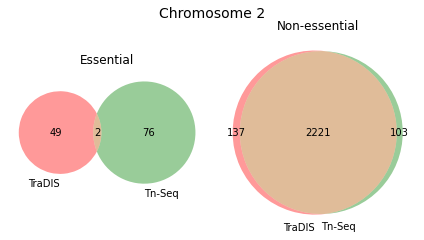

In [2481]:
# only include genes that are in both datasets

essential_tn_seq = []
nonessential_tn_seq = []
undefined_tnseq = []
for i, j in tnseq_phenotypes.items():
    if str(i) != 'nan':
        if 'H16_B' in i:
            if i in tradis_phenotypes_fmm:
                if j == 2:
                    essential_tn_seq.append(i)
                elif j == 0:
                    nonessential_tn_seq.append(i)
                else:
                    undefined_tnseq.append(i)
        
        
essential_tradis2 = []
nonessential_tradis2 = []
undefined_tradis2 = []  
for i, j in tradis_phenotypes_fmm.items():
    if str(i) != 'nan':
        if 'H16_B' in i:
            if i in tnseq_phenotypes:
                if j == 2:
                    essential_tradis2.append(i)
                elif j == 0:
                    nonessential_tradis2.append(i)
                else:
                    undefined_tradis2.append(i)

tradis_tnseq_overlap = len(list(set(essential_tradis2) & set(essential_tn_seq)))        
tradis_essential = len(essential_tradis2) - tradis_tnseq_overlap
tn_seq_essential = len(essential_tn_seq) - tradis_tnseq_overlap

# Make the diagram
figure, axes = plt.subplots(1, 2)
v1 = venn2(subsets = (tradis_essential, tn_seq_essential, tradis_tnseq_overlap), set_labels = ('TraDIS', 'Tn-Seq'), ax = axes[0])
for text in v1.set_labels:
    text.set_fontsize(10)
for text in v1.subset_labels:
    text.set_fontsize(10)
axes[0].title.set_text('Essential')

tradis_tnseq_overlap = len(list(set(nonessential_tradis2) & set(nonessential_tn_seq)))
tradis_nonessential = len(nonessential_tradis2) - tradis_tnseq_overlap
tn_seq_nonessential = len(nonessential_tn_seq) - tradis_tnseq_overlap

v2 = venn2(subsets = (tradis_nonessential, tn_seq_nonessential, tradis_tnseq_overlap), set_labels = ('TraDIS', 'Tn-Seq'), ax = axes[1])
for text in v2.set_labels:
    text.set_fontsize(10)
for text in v2.subset_labels:
    text.set_fontsize(10)
axes[1].title.set_text('Non-essential')
figure.suptitle('Chromosome 2', fontsize=14)

figure.tight_layout()
figure.subplots_adjust(top=1.05)
plt.savefig('Chr2_overlapping_genes.pdf')   

print('Undefined in TraDIS: ', len(undefined_tradis2))
print('Undefined in Tn-Seq: ', len(undefined_tnseq))

#### Megaplasmid 

Undefined in TraDIS:  8
Undefined in Tn-Seq:  5


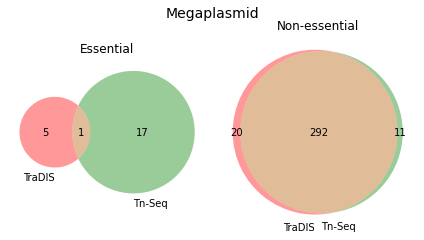

In [2482]:
# only include genes that are in both datasets

essential_tn_seq = []
nonessential_tn_seq = []
undefined_tnseq = []
for i, j in tnseq_phenotypes.items():
    if str(i) != 'nan':
        if 'PHG' in i:
            if i in tradis_phenotypes_fmm:
                if j == 2:
                    essential_tn_seq.append(i)
                elif j == 0:
                    nonessential_tn_seq.append(i)
                else:
                    undefined_tnseq.append(i)
        
        
essential_tradis2 = []
nonessential_tradis2 = []
undefined_tradis2 = []  
for i, j in tradis_phenotypes_fmm.items():
    if str(i) != 'nan':
        if 'PHG' in i:
            if i in tnseq_phenotypes:
                if j == 2:
                    essential_tradis2.append(i)
                elif j == 0:
                    nonessential_tradis2.append(i)
                else:
                    undefined_tradis2.append(i)

tradis_tnseq_overlap = len(list(set(essential_tradis2) & set(essential_tn_seq)))       
tradis_essential = len(essential_tradis2) - tradis_tnseq_overlap
tn_seq_essential = len(essential_tn_seq) - tradis_tnseq_overlap

# Make the diagram
figure, axes = plt.subplots(1, 2)
v1 = venn2(subsets = (tradis_essential, tn_seq_essential, tradis_tnseq_overlap), set_labels = ('TraDIS', 'Tn-Seq'), ax = axes[0])
for text in v1.set_labels:
    text.set_fontsize(10)
for text in v1.subset_labels:
    if text is not None:
        text.set_fontsize(10)
axes[0].title.set_text('Essential')

tradis_tnseq_overlap = len(list(set(nonessential_tradis2) & set(nonessential_tn_seq)))
tradis_nonessential = len(nonessential_tradis2) - tradis_tnseq_overlap
tn_seq_nonessential = len(nonessential_tn_seq) - tradis_tnseq_overlap

v2 = venn2(subsets = (tradis_nonessential, tn_seq_nonessential, tradis_tnseq_overlap), set_labels = ('TraDIS', 'Tn-Seq'), ax = axes[1])
for text in v2.set_labels:
    text.set_fontsize(10)
for text in v2.subset_labels:
    if text is not None:
        text.set_fontsize(10)
axes[1].title.set_text('Non-essential')
figure.suptitle('Megaplasmid', fontsize=14)

figure.tight_layout()
figure.subplots_adjust(top=1.05)
plt.savefig('PHG_overlapping_genes.pdf')   

print('Undefined in TraDIS: ', len(undefined_tradis2))
print('Undefined in Tn-Seq: ', len(undefined_tnseq))

### Possible reasons for the discrepancies

* Lower number of insertions used in the Tn-Seq data may result in some genes not being hit
* Differences in the experimental conditions may have resulted in some differences in phenotypes
* Genes that are partially essential (i.e. contain both essential and non-essential domains) may not be classified correctly using either approach. Manual inspection of the insertions (and their positions in the gene), particularly for those that have an log2(IPKM+1) index that is close to the thresholds is recommended. 

## Simulate single gene deletions in the GSM

In [49]:
def gene_essentiality_statistics(essential, non_essential, essentiality_phenotypes):
    
    TP = []
    FP = []
    undefined = []

    for i in essential:
        if i in essentiality_phenotypes:
            pheno = essentiality_phenotypes[i]
            if pheno == 2:
                TP.append(i)
            elif pheno == 0:
                FP.append(i)
            else:
                undefined.append(i)
        else:
            undefined.append(i)


    TN = []
    FN = []
    for i in non_essential:
        if i in essentiality_phenotypes:
            pheno = essentiality_phenotypes[i]
            if pheno == 0:
                TN.append(i)
            elif pheno == 2:
                FN.append(i)
            else:
                undefined.append(i)
        else:
            undefined.append(i)
            
            
    return TP, FP, TN, FN, undefined







In [50]:
# Add column to excel file with GSM result
m.reactions.R_Biomass.bounds = (0.0, 1000.0)

# minimal media
essential = []
non_essential = []
growth_limiting = []
oxygen = []
sol_wt = pfba(m)
growth_wt = sol_wt['R_Biomass']
oxygen_wt = sol_wt['EX_OXYGEN_MOLECULE_e']
for ind, i in enumerate(m.genes):
    #print(ind, i.id)
    with m:
        m.genes.get_by_id(i.id).knock_out()
        try:
            sol_ko = m.optimize()
            if sol_ko.status != 'infeasible':
                if sol_ko['R_Biomass'] > 0.05:
                    #print(sol_ko['R_Biomass'])
                    non_essential.append(i.id)
                    if sol_ko['R_Biomass'] < growth_wt*0.85:
                        growth_limiting.append(i.id)
                    if sol_ko['EX_OXYGEN_MOLECULE_e'] < oxygen_wt*1.01:
                        oxygen.append(i.id)
                        #print(i.id, sol_ko['EX_OXYGEN_MOLECULE_e'])
                else:
                    essential.append(i.id)
            
            else:
                essential.append(i.id)

        except:
            essential.append(i.id)
            
            
            
           

/opt/anaconda2/envs/pyTFA_2/lib/python3.7/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


### Simulate reaction deletions to check if the reaction is essential

In [51]:

# minimal media
essential_reacs = []
non_essential_reacs = []
growth_limiting_reacs = {}

#m.reactions.EX_OXYGEN_MOLECULE_e.bounds = (-3.0, 1000.0)

for i in m.reactions:
    #print(ind, i.id)

    with m:
        m.reactions.get_by_id(i.id).bounds = (0.0, 0.0)
        try:
            sol_ko = m.optimize()
            if sol_ko.status != 'infeasible':
                if sol_ko['R_Biomass'] > 0.05:
                    non_essential_reacs.append(i.id)
                else:
                    essential_reacs.append(i.id)
            else:
                essential_reacs.append(i.id)
        except:
            essential_reacs.append(i.id)




In [172]:
# save essential reactions to be loaded for determining the lower cutoff in 'GSM_nitrogenlimitation.ipynb'
with open('Cnec_essential_reactions.json', 'w') as fn:
    json.dump(essential_reacs, fn)

In [52]:
TP_tradis, FP_tradis, TN_tradis, FN_tradis, undefined_tradis = gene_essentiality_statistics(essential, non_essential, tradis_phenotypes_fmm)

print('True positives: ', len(TP_tradis))
print('False positives: ', len(FP_tradis))
print('True negatives: ', len(TN_tradis))
print('False negatives: ', len(FN_tradis))
print('Undefined genes: ', len(undefined_tradis))

print('Overall accuracy iC1361: ', (len(TP_tradis) + len(TN_tradis))/(len(TP_tradis) + len(TN_tradis) + len(FN_tradis) + len(FP_tradis)))
print('Precision iCN1361: ', len(TP_tradis)/(len(TP_tradis)+ len(FP_tradis)))
print('Recall iCN136: ', len(TP_tradis)/(len(TP_tradis) + len(FN_tradis)))
print('')

True positives:  127
False positives:  29
True negatives:  1080
False negatives:  79
Undefined genes:  47
Overall accuracy iC1361:  0.9178707224334601
Precision iCN1361:  0.8141025641025641
Recall iCN136:  0.616504854368932



In [53]:
# how many of the 141 are from essential reactions? so isoenzyme issue
FN_reac_ess = []
other = []
count = 0
for gene in FN_tradis:
    check = 0
    for r in m.genes.get_by_id(gene).reactions:
        if r.id in essential_reacs:
            FN_reac_ess.append(gene)
            count += 1
            check = 1
    if check == 0:
        other.append(gene)
            
print(count)
print(len(set(other)))
print(len(set(FN_reac_ess)))



98
49
30


In [55]:
print('number of FN genes that are associated to an essential reactions: ',  len(set(FN_reac_ess)))



number of FN genes that are associated to an essential reactions:  30


### Save results to excel

In [62]:
# to excel file
genes = []
for i in m.genes:
    if i.id != 'Spontaneous':
        genes.append(i.id)
        
df = pd.DataFrame(index = genes)

GSM_essentiality = []
log2_fmm = []
log2_sob = []
tradis_essentiality = []
low_cov_fmm = []
low_cov_sob = []
tnseq_essentiality = []

for i in genes:
    if i in essential:
        GSM_essentiality.append(0)
    elif i in non_essential:
        GSM_essentiality.append(1)
    
    if i in log2_IPKM:
        log2_fmm.append(log2_IPKM[i])
        log2_sob.append(log2_IPKM_sob[i])
    else:
        log2_fmm.append('')
        log2_sob.append('')

        
    if i in low_coverage_fmm:
        low_cov_fmm.append(1)
    else:
        low_cov_fmm.append(0)
        
    if i in low_coverage_sob:
        low_cov_sob.append(1)
    else:
        low_cov_sob.append(0)
        
    if i in tnseq_phenotypes:
        if tnseq_phenotypes[i] == 2:
            tnseq_essentiality.append(0)
        elif tnseq_phenotypes[i] == 0:
            tnseq_essentiality.append(1)
        else:
            tnseq_essentiality.append('')
    else:
        tnseq_essentiality.append('')
        
        
    if i in tradis_phenotypes_fmm:
        if tradis_phenotypes_fmm[i] == 2:
            tradis_essentiality.append(0)
        elif tradis_phenotypes_fmm[i] == 0:
            tradis_essentiality.append(1)
        else:
            tradis_essentiality.append('')
    else:
        tradis_essentiality.append('')
        
df.insert(0, column= 'GSM prediction (0 - essential, 1 - non-essential)', value = GSM_essentiality)
df.insert(1, column= 'log2 (IPKM_FMM + 1)', value = log2_fmm)
df.insert(2, column = 'log2 (IPKM_SOB + 1)', value = log2_sob)
df.insert(3, column = 'Essential in TraDIS (log2(IPKM+1) < 3.9)', value = tradis_essentiality)
df.insert(4, column = 'Low coverage in TraDIS result (FMM)?', value = low_cov_fmm)
df.insert(5, column = 'Low coverage in TraDIS result (SOB)?', value = low_cov_sob)

classification_group = []

for ind, i in enumerate(df['GSM prediction (0 - essential, 1 - non-essential)']):
    if i == 0 and df['Essential in TraDIS (log2(IPKM+1) < 3.9)'][ind] == 0:
        classification_group.append('TP')
    elif i == 0 and df['Essential in TraDIS (log2(IPKM+1) < 3.9)'][ind] == 1:
        classification_group.append('FP')
    elif i == 1 and df['Essential in TraDIS (log2(IPKM+1) < 3.9)'][ind] == 0:
        classification_group.append('FN')
    elif i == 1 and df['Essential in TraDIS (log2(IPKM+1) < 3.9)'][ind] == 1:
        classification_group.append('TN')
    else:
        classification_group.append('')

        
        
    
        
df.insert(6, column = 'Classification', value = classification_group)
df.insert(7, column = 'Essential in Tn-Seq?', value = tnseq_essentiality)

    
        

### Get Biocyc Pathways of the reactions in the FP and FN

In [63]:
reac_info = pd.read_excel('../SupplementaryFiles/SupplementaryFile1_GSMinfo.xlsx', sheet_name='Table S1')

In [64]:
biocyc_pathways = {}
for ind, i in enumerate(reac_info['Unnamed: 0']):
    biocyc_pathways[i] = reac_info['BioCyc pathways'][ind]

In [79]:
FN_gene_pathways = {}
for i in FN_tradis:
    pathways = []
    for r in m.genes.get_by_id(i).reactions:
        if str(biocyc_pathways[r.id]) != 'nan':
            paths = biocyc_pathways[r.id].split(' // ')
            for p in paths:
                pathways.append(p)
    FN_gene_pathways[i] = list(set(pathways))
    
    

        
FP_gene_pathways = {}
for i in FP_tradis:
    pathways = []
    for r in m.genes.get_by_id(i).reactions:
        if str(biocyc_pathways[r.id]) != 'nan':
            paths = biocyc_pathways[r.id].split(' // ')
            for p in paths:
                pathways.append(p)
    FP_gene_pathways[i] = list(set(pathways))

### Gene KO results in model with reduced growth rate by > 15% of wild type

In [80]:
for i in FN_tradis:
    if i in growth_limiting:
        print(i, log2_IPKM[i], tnseq_phenotypes[i])

H16_A1053 1.1785553065857524 2
H16_A1060 2.2602063580105263 0
H16_A1052 3.8971435971549573 2
H16_A1055 1.8184824794950725 2
H16_A1050 3.2993618976515586 2
H16_A1063 2.8713902714594597 2
H16_A1051 1.1785553065857524 2
H16_A1058 1.1785553065857524 2
H16_A1057 1.1785553065857524 2
H16_A2631 0.0 2
H16_A2630 3.101196221324343 2
H16_A2632 0.0 2
H16_A2629 4.2241715065608085 2


### Gene KO results in model requiring increased oxygen uptake

In [81]:
for i in oxygen:
    if i not in growth_limiting and i in FN_tradis:
        print(i, log2_IPKM[i], tnseq_phenotypes[i])
        
        

H16_A2325 3.101196221324343 2
H16_A2324 1.8184824794950725 2
H16_A1188 1.1785553065857524 2


### Check whether isoenzymes are on in expression data

#### Function for calculating reaction expression

In [69]:
### reactions to block

def map_exp_to_reacs(m, gene_express, condition = 'f16', unconstrained_reacs = []):
    
    reac_expression = {}
    reacs_low_expression = []
    for r in m.reactions:
        if r.id not in unconstrained_reacs:

            # get a list of 'or' genes that includes 'and' genes in internal list
            genes = r.gene_reaction_rule.split('or')
            genes_or = []
            for g in genes:
                gene = g.replace(' ', '').replace('(', '').replace(')', '')
                genes_or.append(gene.split('and'))


            # loop through genes - get the sum of expression of the 'or' genes
            exp_max = 0.0
            for g in genes_or:

                # get minimum
                min_gene_and = 0.0
                if g[0] in list(gene_express['gene']):
                    for ind, gene_tag in enumerate(gene_express['gene']):
                        if gene_tag == g[0]:
                            min_gene_and = gene_express[condition][ind] # if not in the list then leave as preset zero


                # if more than one gene in list ('and' relationship)  
                if len(g) > 1:
                    for gi in g[1:]: # loop through rest of genes in 'and' list and check if in the proteomics data
                        if gi in list(gene_express['gene']):
                            for ind, gene_tag in enumerate(gene_express['gene']):
                                if gene_tag == gi:
                                    if gene_express[condition][ind] < min_gene_and: # if less than value already set then re-value
                                        min_gene_and = gene_express[condition][ind]

                exp_max += min_gene_and # add to the 'or' expression 
                
                # store expression for each reaction
                reac_expression[r.id] = exp_max
        else:
            reac_expression[r.id] = -1
                

                
                
    
    return reac_expression
                


        
                    
        
    
    

    

In [70]:
gene_express = pd.read_excel('Data/gene_exp_fructose.xlsx')
# exclude transport and spontaneous reactions
unconstrained_reacs = ['R_ATPM', 'R_Biomass']
for r in m.reactions:
    if 'EX_' in r.id:
        unconstrained_reacs.append(r.id)
    if r.gene_reaction_rule == 'Spontaneous':
        unconstrained_reacs.append(r.id)
    if r.gene_reaction_rule == '':
        unconstrained_reacs.append(r.id)
        
RPKM_f16 = map_exp_to_reacs(m, gene_express, condition = 'f16', unconstrained_reacs = unconstrained_reacs)
RPKM_f26 = map_exp_to_reacs(m, gene_express, condition = 'f26', unconstrained_reacs = unconstrained_reacs)








In [82]:
FN_isoenzymes_exp_ratios = {}
count = 0
# Turn off the genes that are not expressed in the isoenzymes
genes_isoenzymes = list(set(FN_reac_ess)) # all FN genes associated to essential reactions
ess_genes = []
ess_genes_dic = {}
for i in genes_isoenzymes:
    for ind, gene in enumerate(gene_express['gene']):
        if i == gene:
            ess_gene_exp = gene_express['f16'][ind]

            
    
    # get the 'or' relationships
    isoenzymes_expressions = {}
    for r in m.genes.get_by_id(i).reactions:
        if r.id in essential_reacs: # find the essential reac its associated to
            if 'and' not in r.gene_reaction_rule:
                isoenzyme_express_reac = []
                isoenzyme_exp_dic = {}
                for g in r.genes:
                    if g.id != i:
                        match = 0 # check if the other genes associtaed to reaction are in the expression data (if not assign very small expression value)
                        for ind, gene in enumerate(gene_express['gene']):
                            if g.id == gene:
                                isoenzyme_express_reac.append(gene_express['f16'][ind]/ess_gene_exp) # divide the expression of other gene by the expression of FN gene under consideration
                                isoenzyme_exp_dic[g.id] = gene_express['f16'][ind]
                                match = 1
                        if match == 0:
                            isoenzyme_exp_dic[g.id] = 0.000000001
                            isoenzyme_express_reac.append(0.000000001)
                                
                                
                if all(x <= 0.2 for x in isoenzyme_express_reac): # if all the genes
                    FN_isoenzymes_exp_ratios[i] = isoenzyme_exp_dic
                    ess_genes.append(i)
                    ess_genes_dic[i] = ess_gene_exp
                    
            else:
                isoenzyme_express_reac = []
                isoenzyme_exp_dic = {}
                or_genes = r.gene_reaction_rule.split(' or ')
                #print(or_genes)
                for ors in or_genes:
                    if i in ors:
                        genes_and = ors.split(' and ')

                        exp = []
                        for gi in genes_and:
                            gi = gi.replace('( ', '')
                            gi = gi.replace(' )', '')
                            gi = gi.replace('(', '')
                            gi = gi.replace(')', '')
                            match = 0
                            for ind, gene in enumerate(gene_express['gene']):
                                if gi == gene:
                                    exp.append(gene_express['f16'][ind])
                                    isoenzyme_exp_dic[gi] = gene_express['f16'][ind]

                                    match = 1
                            if match == 0:
                                exp.append(0.000000001)
                                isoenzyme_exp_dic[g.id] = 0.000000001

                        i_min_exp = np.min(exp)
                        #print(i_min_exp)


                for ors in or_genes: 

                    if i not in ors:
                        genes_and = ors.split(' and ')
                            #print(genes_and)
                        exp = []
                        for gi in genes_and:
                            gi = gi.replace('( ', '')
                            gi = gi.replace(' )', '')
                            gi = gi.replace('(', '')
                            gi = gi.replace(')', '')
                            match = 0
                            for ind, gene in enumerate(gene_express['gene']):
                                if gi == gene:
                                    exp.append(gene_express['f16'][ind])
                                    isoenzyme_exp_dic[gi] = gene_express['f16'][ind]
                                    match = 1
                            if match == 0:
                                exp.append(0.000000001)
                                isoenzyme_exp_dic[g.id] = 0.000000001


                        isoenzyme_express_reac.append(np.min(exp)/i_min_exp)

                        min_exp = np.min(exp)
                        #print(isoenzyme_express_reac)




                if all(x <= 0.2 for x in isoenzyme_express_reac):
                    ess_genes.append(i)
                    ess_genes_dic[i] = ess_gene_exp
                    FN_isoenzymes_exp_ratios[i] = isoenzyme_exp_dic
        
                        

   
                        
len(set(ess_genes))       

16

### Calculate the updated accuracy measures with the isoenzymes blocked in the model if their expression is significantly less than the FN gene

In [83]:
tp_updated = TP_tradis + list(set(ess_genes))
fn_updated = []
for i in FN_tradis:
    if i not in ess_genes:
        fn_updated.append(i)
fp = FP_tradis
tn = TN_tradis

In [84]:
print('Overall accuracy: ', (len(tp_updated) + len(tn))/(len(tp_updated) + len(tn) + len(fn_updated) + len(fp)))
print('Precision: ', len(tp_updated)/(len(tp_updated)+ len(fp)))
print('Recall: ', len(tp_updated)/(len(tp_updated) + len(fn_updated)))

Overall accuracy:  0.9300380228136882
Precision:  0.8313953488372093
Recall:  0.6941747572815534


### Save FP information in the Excel file

In [85]:
df_FP_genes = pd.DataFrame(index = list(FP_gene_pathways.keys()))
pathways = []
tnseq_essentiality_FP = []
for i, j in FP_gene_pathways.items():
    pathways.append(str(j))
    if i in tnseq_phenotypes:
        if tnseq_phenotypes[i] == 2:
            tnseq_essentiality_FP.append('Agreement with GSM predictions')
        elif tnseq_phenotypes[i] == 0:
            tnseq_essentiality_FP.append('Agreement with TraDIS predictions')
        else:
            tnseq_essentiality_FP.append('')
    else:
        tnseq_essentiality_FP.append('')
            
df_FP_genes.insert(0, column = 'Metabolic pathways', value = pathways)
df_FP_genes.insert(1, column = 'Tn-Seq prediction', value = tnseq_essentiality_FP)





df_FN_genes = pd.DataFrame(index = list(FN_gene_pathways.keys()))
pathways = []
reason = []
tnseq_essentiality_FN = []
for i, j in FN_gene_pathways.items():
    pathways.append(str(j))
    
    if i in growth_limiting:
        reason.append('Reduced growth rate of mutant by > 15% than wild type')        
    elif i in oxygen:
        reason.append('Increased oxygen requirement in mutant')        
    elif i in FN_reac_ess:
        if i in ess_genes:
            reason.append('Associated to essential reaction - highest expressed isoenzyme')
        else:
            reason.append('Associated to essential reaction')
    else:
        reason.append('')
        
        
    if i in tnseq_phenotypes:
        if tnseq_phenotypes[i] == 2:
            tnseq_essentiality_FN.append('Agreement with TraDIS predictions')
        elif tnseq_phenotypes[i] == 0:
            tnseq_essentiality_FN.append('Agreement with GSM predictions')
        else:
            tnseq_essentiality_FN.append('')
    else:
        tnseq_essentiality_FN.append('')
        
    
        
        
        
df_FN_genes.insert(0, column = 'Metabolic pathways', value = pathways)
df_FN_genes.insert(1, column = 'Potential reason', value = reason)
df_FN_genes.insert(2, column = 'Tn-seq prediction', value = tnseq_essentiality_FN)







#### write all dataframes to excel

In [88]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('SupplementaryFile4_GeneEssentiality_new.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
df.to_excel(writer, sheet_name='GSM_essentiality_assessment')
df_FP_genes.to_excel(writer, sheet_name='False positives')
df_FN_genes.to_excel(writer, sheet_name='False negatives')


# Close the Pandas Excel writer and output the Excel file.
writer.save()

### Compare the false positives and false negatives to the Tn-Seq data

In [42]:
TP_tnseq, FP_tnseq, TN_tnseq, FN_tnseq, undefined = gene_essentiality_statistics(essential, non_essential, tnseq_phenotypes)

print('True positives: ', len(TP_tnseq))
print('False positives: ', len(FP_tnseq))
print('True negatives: ', len(TN_tnseq))
print('False negatives: ', len(FN_tnseq))
print('Undefined genes: ', len(undefined))

print('Overall accuracy iC1361: ', (len(TP_tnseq) + len(TN_tnseq))/(len(TP_tnseq) + len(TN_tnseq) + len(FN_tnseq) + len(FP_tnseq)))
print('Precision iCN1361: ', len(TP_tnseq)/(len(TP_tnseq)+ len(FP_tnseq)))
print('Recall iCN136: ', len(TP_tnseq)/(len(TP_tnseq) + len(FN_tnseq)))
print('')

True positives:  119
False positives:  35
True negatives:  1058
False negatives:  113
Undefined genes:  37
Overall accuracy iC1361:  0.8883018867924528
Precision iCN1361:  0.7727272727272727
Recall iCN136:  0.5129310344827587

